**Social Sentiment and Stock Price Correlation**

See if the Apple stock price is correlated to the Twitter messages

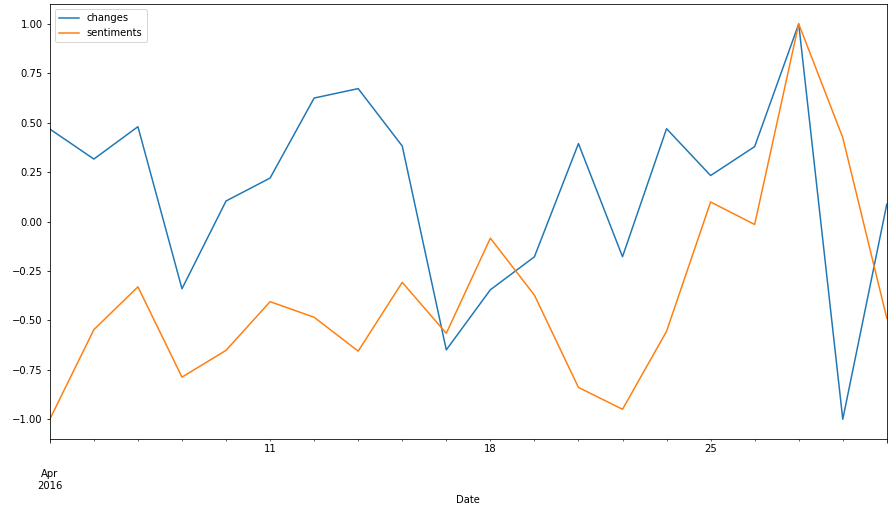



In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# TextBlob for Sentiment Analysis
from textblob import TextBlob

# For plotting word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

pd.options.mode.chained_assignment = None

# combine multiple words into one single word
# e.g. very good -> very_good
def combineWord(words):
  combined = ""
  for word in words:
    combined += word + "_"

  return combined[:len(combined)-1]


# get the sentiment polarity and assessment from Textblob
def getSentiments(content):
  tb = TextBlob(content)
  assessmentsList = []

  for assessments in tb.sentiment_assessments.assessments:
    assessmentsList.append((combineWord(assessments[0]), assessments[1]))

  return tb.polarity, assessmentsList


def getCount(countDict, word):
	if word in countDict:
		return countDict[word] + 1
	else:
		return 1


def plotWordCloud(freqDict, numWords):
  WIDTH, HEIGHT = 800, 600
  BG_COLOR = "black" # white

  wordcloud = WordCloud(max_words=numWords, stopwords='', width=WIDTH, height=HEIGHT, background_color=BG_COLOR).fit_words(freqDict)  
  plt.figure(figsize=[15,10])
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

Sentiment analysis by TextBlob
* polarity is a float within the range [-1.0, 1.0] where -1 is very negative and 1.0 is very positive
* subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective
* Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information

In [2]:
sentence = 'This class is interesting'

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
print('subjectivity=', tb.subjectivity)

This class is interesting
polarity= 0.5
subjectivity= 0.5


Textblob is rule and pattern based.

https://planspace.org/20150607-textblob_sentiment/
https://github.com/sloria/TextBlob/blob/eb08c120d364e908646731d60b4e4c6c1712ff63/textblob/en/en-sentiment.xml
* `<word form="interesting" wordnet_id="a-01343918" pos="JJ" sense="arousing or holding the attention" polarity="0.5" subjectivity="0.5" intensity="1.0" confidence="0.9" />`
* pos="JJ" (adjective)

In [3]:
tb.sentiment_assessments

Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['interesting'], 0.5, 0.5, None)])

Handle “modifier” such as "very"
* `<word form="very" wordnet_id="r-00031899" pos="RB" sense="used as intensifier" polarity="0.2" subjectivity="0.3" intensity="1.3" confidence="0.9" />`
* "very" intensity="1.3"

In [5]:
sentence = 'This class is very interesting'

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
tb.sentiment_assessments

This class is very interesting
polarity= 0.65


Sentiment(polarity=0.65, subjectivity=0.65, assessments=[(['very', 'interesting'], 0.65, 0.65, None)])

Handle “negation” such as "not"
* `self.negations   = kwargs.get("negations", ("no", "not", "n't", "never"))`

In [6]:
sentence = 'This class is not interesting'

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
tb.sentiment_assessments

This class is not interesting
polarity= -0.25


Sentiment(polarity=-0.25, subjectivity=0.5, assessments=[(['not', 'interesting'], -0.25, 0.5, None)])

Handle mood (Emoticons)

https://github.com/sloria/TextBlob/blob/dev/textblob/_text.py#L223
* `("smile", +0.50): set((">:)", ":-)", ":)", "=)", "=]", ":]", ":}", ":>", ":3", "8)", "8-)"))`

In [7]:
sentence = 'oh :)'

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
tb.sentiment_assessments

oh :)
polarity= 0.5


Sentiment(polarity=0.5, subjectivity=1.0, assessments=[([':)'], 0.5, 1.0, 'mood')])

* Understand profanity (dirty word) 
* Don't understand punctuation (probably the punctuations are removed in the text pre-processing step)

In [8]:
print(TextBlob("he is a moron").sentiment_assessments)
print(TextBlob("who is the moron?").sentiment_assessments)

Sentiment(polarity=-0.8, subjectivity=1.0, assessments=[(['moron'], -0.8, 1.0, 'profanity')])
Sentiment(polarity=-0.8, subjectivity=1.0, assessments=[(['moron'], -0.8, 1.0, 'profanity')])


In [9]:
# A sentence contains both positive and negative adjectives
sentence = "This class is interesting but the content is too tough"

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
tb.sentiment_assessments

This class is interesting but the content is too tough
polarity= 0.05555555555555555


Sentiment(polarity=0.05555555555555555, subjectivity=0.6666666666666667, assessments=[(['interesting'], 0.5, 0.5, None), (['tough'], -0.3888888888888889, 0.8333333333333334, None)])

Averaging the sentiment scores for the overall polarity: "interesting" and "tough"

In [10]:
# mild has different meanings 
sentence = 'The effect of the drug is mild'

print(sentence)
tb = TextBlob(sentence)
print('polarity=', tb.polarity)
tb.sentiment_assessments

The effect of the drug is mild
polarity= 0.3333333333333333


Sentiment(polarity=0.3333333333333333, subjectivity=0.5, assessments=[(['mild'], 0.3333333333333333, 0.5, None)])

When a word (such as "mild") has different meaning in context, again use averaging

* `<word form="mild" cornetto_synset_id="n_a-518871" wordnet_id="a-01893510" pos="JJ" sense="humble in spirit or manner" polarity="0.5" subjectivity="0.5" intensity="1.0" confidence="0.9" />`

* `<word form="mild" cornetto_synset_id="n_a-535263" wordnet_id="a-00438332" pos="JJ" sense="mild and pleasant" polarity="0.5" subjectivity="0.5" intensity="1.0" confidence="0.9" />`

* `<word form="mild" wordnet_id="a-01508719" pos="JJ" sense="moderate in type or degree or effect or force" polarity="0.0" subjectivity="0.5" intensity="1.0" confidence="0.9" />`


In [11]:
# Get the tweet data source
url = 'https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/appleTweets.xlsx'
appleTweets = pd.read_excel(url)

appleTweets.shape

(74801, 19)

In [12]:
# Show partial results
appleTweets[:10]

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Country,Place (as appears on Bio),Followers,Following,Listed,Tweet language (ISO 639-1),Is a RT,User Mentions,Hashtags,Symbols
0,726561352882524160,2016-04-30,23:58,Warren of Wall St,WarrenofWallSt,Warren is the @SimplyWallSt mascot who helps y...,$AAPL management and CEO infographic https://t...,1.0,1.0,NaN,NaN,375.0,431.0,29.0,en,False,NaN,NaN,$AAPL
1,726560818683215872,2016-04-30,23:56,AlejandroMasari,AlejandroDinero,Passionate about coaching & teaching clients h...,the criminal media does fools investors once a...,NaN,1.0,CA,Canada,545.0,771.0,27.0,en,False,NaN,NaN,"$aapl,$spy,$qqq"
2,726560521076396032,2016-04-30,23:55,Cody Freeman,ZenTrends,NaN,@rpatel83 ha it's ok. I've been very clear sin...,NaN,NaN,NaN,NaN,1058.0,170.0,67.0,en,False,@RPatel83,NaN,$AAPL
3,726559661718179844,2016-04-30,23:51,FinBuzz,PortfolioBuzz,"Financial #bigdata crowd-sourced, crowd-curate...",Monitor your watchlist of assets for tweets - ...,NaN,NaN,GB,London,817.0,885.0,267.0,en,False,NaN,NaN,"$AAPL,$GOOGL,$MSFT,$FB,$TWTR"
4,726559467353964545,2016-04-30,23:50,Taylor,Trading_Analyst,-------- CMT Level II Candidate ------- The m...,{NEW POST} ANALYSIS + TRADE IDEAS: $AAPL $TSLA...,NaN,NaN,NaN,NaN,1785.0,22.0,56.0,en,False,NaN,NaN,"$AAPL,$TSLA,$AMZN,$NFLX,$GPRO,$TWTR"
5,726559151917260800,2016-04-30,23:49,VR Games,Cardboard_VR,I RT everything #vr follow me for more exposu...,RT @BrianDColwell: #VirtualReality: The Next #...,NaN,3.0,NaN,NaN,10793.0,219.0,2600.0,en,True,@BrianDColwell,"#VirtualReality,#3DPrinting,#VR,#disruptivetec...","$AAPL,$FB,$GOOG,$MSFT,$SNE,$LNVGY,$SSYS,$ARKW"
6,726559099563859969,2016-04-30,23:49,Cody Freeman,ZenTrends,NaN,$AAPL Monthly line chart. Lowest monthly close...,6.0,5.0,NaN,NaN,1059.0,170.0,67.0,en,False,NaN,NaN,$AAPL
7,726558155359002625,2016-04-30,23:45,Invest Huddle,InvestHuddle,"a gathering to motivate, strategize and update...",Have we reached peak Apple? https://t.co/8q6pj...,NaN,NaN,NaN,NaN,369.0,602.0,96.0,en,False,NaN,NaN,$AAPL
8,726558053726707712,2016-04-30,23:45,TheChartGuys,ChartGuys,NaN,$AAPL Technical Analysis Video. 4/29/2016 http...,NaN,NaN,NaN,NaN,854.0,1250.0,28.0,es,False,NaN,NaN,$AAPL
9,726557750554181632,2016-04-30,23:44,Stock_Huntress,Stock_Huntress,NaN,Fous4x2 #daytrading DVD review: https://t.co/k...,1.0,NaN,NaN,NaN,257.0,40.0,70.0,en,False,NaN,#daytrading,"$AAPL,$FXCM,$HIMX,$ASPS,$AAL"


In [ ]:
appleTweets.columns

In [13]:
# Look at the subset of useful columns for the sentiment trading
COLUMNS = ['Date', 'User Name', 'Tweet content', 'Following', 'Hashtags']
appleTweetsSubset = appleTweets[COLUMNS]

appleTweetsSubset[:10]

,Date,User Name,Tweet content,Following,Hashtags
0,2016-04-30,Warren of Wall St,$AAPL management and CEO infographic https://t...,431.0,NaN
1,2016-04-30,AlejandroMasari,the criminal media does fools investors once a...,771.0,NaN
2,2016-04-30,Cody Freeman,@rpatel83 ha it's ok. I've been very clear sin...,170.0,NaN
3,2016-04-30,FinBuzz,Monitor your watchlist of assets for tweets - ...,885.0,NaN
4,2016-04-30,Taylor,{NEW POST} ANALYSIS + TRADE IDEAS: $AAPL $TSLA...,22.0,NaN
5,2016-04-30,VR Games,RT @BrianDColwell: #VirtualReality: The Next #...,219.0,"#VirtualReality,#3DPrinting,#VR,#disruptivetec..."
6,2016-04-30,Cody Freeman,$AAPL Monthly line chart. Lowest monthly close...,170.0,NaN
7,2016-04-30,Invest Huddle,Have we reached peak Apple? https://t.co/8q6pj...,602.0,NaN
8,2016-04-30,TheChartGuys,$AAPL Technical Analysis Video. 4/29/2016 http...,1250.0,NaN
9,2016-04-30,Stock_Huntress,Fous4x2 #daytrading DVD review: https://t.co/k...,40.0,#daytrading


In [14]:
# Count Duplicates 
print('Duplicate content count=', appleTweetsSubset[['Tweet content']].duplicated().sum())

# Remove duplicate
print("Original row# :", appleTweetsSubset.shape[0])
appleTweetsSubset = appleTweetsSubset.drop_duplicates(subset='Tweet content', keep='first')
print("Row after removed duplicates# :", appleTweetsSubset.shape[0])

Duplicate content count= 23712
Original row# : 74801
Row after removed duplicates# : 51089


In [15]:
# Filter the contents with the number of followings
MIN_FOLLOWING = 500

# Filter tweet with at least the MIN_FOLLOWING
appleTweetsFiltered = appleTweetsSubset[(appleTweetsSubset['Following'] >= MIN_FOLLOWING)]
appleTweetsFiltered.reset_index(drop=True, inplace=True)

print("Original row# :", appleTweetsSubset.shape[0])
print("Filtered row# :", appleTweetsFiltered.shape[0])

Original row# : 51089
Filtered row# : 17788


In [16]:
# interactive table max_rows = 20000
SHOW_NUMS = 20000
appleTweetsFiltered[:SHOW_NUMS]

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# count the hastags frequencies
hashtagsCount = {}

for hashtags in appleTweetsFiltered['Hashtags']:
  if type(hashtags) == str:
    for hashtag in hashtags.split(","):
      tag = hashtag.strip().lower()
      hashtagsCount[tag] = getCount(hashtagsCount, tag)

hashtagsDf = pd.DataFrame.from_dict(hashtagsCount, orient='index', columns= ['count']).sort_values('count', ascending=False)
hashtagsDf

,count
#apple,1465
#stocks,1388
#cannabis,1113
#weedstocks,1109
#breakingnews,1108
...,...
#puts,1
#risk,1
#teach,1
#easy,1


*   Use **TextBlob** to get the sentiment **assessment** and **polarity** of each Tweet content
*   Weight the tweets sentiment importance by the number of followings (**sentiment_weighted**)


In [18]:
# Use TextBlob to run the tweets sentiment polarity
appleTweetsFiltered['sentiment'], appleTweetsFiltered['assessments'] = zip(*appleTweetsFiltered['Tweet content'].apply(getSentiments))

# Weight the tweets sentiment importance by the number of followings
appleTweetsFiltered['sentiment_weighted'] = appleTweetsFiltered['sentiment'] * appleTweetsFiltered['Following']

SENTIMENT_COLS = ['Tweet content', 'assessments', 'sentiment', 'Following', 'sentiment_weighted']
appleTweetsFiltered[SENTIMENT_COLS][:SHOW_NUMS]

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# see the sentiment distribution histogram
import plotly.express as px
fig = px.histogram(appleTweetsFiltered, x="sentiment", title='Sentiment Polarity Distribution', nbins=50)
fig.show()

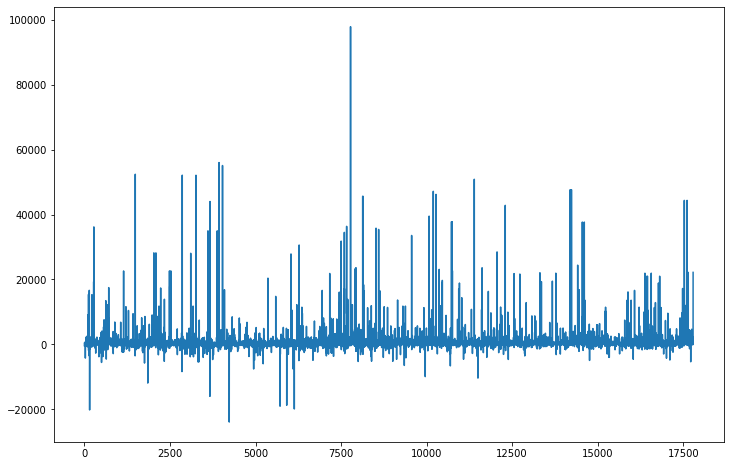

In [20]:
# Plot the sentiment_weighted
appleTweetsFiltered['sentiment_weighted'].plot(figsize=(12, 8))

In [21]:
# count the positive, neutral and negative sentiment words
positiveWordCounts = {}
negativeWordCounts = {}
neutralWordCounts = {}
allWordsSentiment = {}

for assessments in appleTweetsFiltered['assessments']:
	for assessment in assessments:
		allWordsSentiment[assessment[0]] = assessment[1]
		
		if assessment[1] > 0:
			positiveWordCounts[assessment[0]] = getCount(positiveWordCounts, assessment[0])
		elif assessment[1] < 0:
			negativeWordCounts[assessment[0]] = getCount(negativeWordCounts, assessment[0])
		else:
			neutralWordCounts[assessment[0]] = getCount(neutralWordCounts, assessment[0])

In [ ]:
#Plot the positive WordCloud
plotWordCloud(positiveWordCounts, 100)

In [ ]:
#Plot the negative WordCloud
plotWordCloud(negativeWordCounts, 100)

In [ ]:
#Plot the neutral WordCloud
plotWordCloud(neutralWordCounts, 100)

In [ ]:
# use dataframe table to see all the sentiment poloarity and counts
allWordCountsDict = {**positiveWordCounts, **negativeWordCounts, **neutralWordCounts}
wordCountsDictDf = pd.DataFrame.from_dict(allWordCountsDict, orient='index', columns=['count'])
wordsSentimentDf = pd.DataFrame.from_dict(allWordsSentiment, orient='index', columns=['sentiment'])
allWordsDf = wordsSentimentDf.merge(wordCountsDictDf, left_index=True, right_index=True)
allWordsDf.sort_values(by=['count'], ascending=False)

In [25]:
# Group the weighted sentiment by Date for matching the stock daily change

# Convert Date string to datetime to match with the stock daily change later
appleTweetsFiltered['Date'] = pd.to_datetime(appleTweetsFiltered['Date'])

aggregateSentiments = appleTweetsFiltered.groupby(['Date']).sum()[['sentiment_weighted']]
aggregateSentiments

,sentiment_weighted
Date,
2016-04-02,42310.496085
2016-04-03,285426.034145
2016-04-04,113380.546533
2016-04-05,214449.195751
2016-04-06,262688.958560
2016-04-07,160834.644683
2016-04-08,191073.503751
2016-04-09,203720.688090
2016-04-10,107394.186080


In [22]:
# get stocks daily data (OHLCV) from Yahoo finance
url = 'https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/appleStock201604.csv'
stock = pd.read_csv(url)
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.set_index("Date")
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-04-04,25.632113,26.042989,25.597293,25.794607,149424800,0,0
2016-04-05,25.420874,25.704076,25.399981,25.490513,106314800,0,0
2016-04-06,25.588007,25.762107,25.348909,25.757463,105616400,0,0
2016-04-07,25.523008,25.632111,25.098206,25.195702,127207600,0,0
2016-04-08,25.281594,25.481226,25.109814,25.223560,94326800,0,0
2016-04-11,25.295525,25.676223,25.263027,25.307131,117630000,0,0
2016-04-12,25.381409,25.650684,25.223561,25.636757,108929200,0,0
2016-04-13,25.720327,26.077810,25.720327,26.008171,133029200,0,0
2016-04-14,25.910676,26.089417,25.843357,26.022099,101895600,0,0


In [23]:
# calculate the stock daily change
stock['change'] = (stock['Close'] - stock['Open']) / stock['Open']
stock[['Open', 'Close', 'change']]

,Open,Close,change
Date,,,
2016-04-04,25.632113,25.794607,0.006339
2016-04-05,25.420874,25.490513,0.002739
2016-04-06,25.588007,25.757463,0.006622
2016-04-07,25.523008,25.195702,-0.012824
2016-04-08,25.281594,25.223560,-0.002295
2016-04-11,25.295525,25.307131,0.000459
2016-04-12,25.381409,25.636757,0.010060
2016-04-13,25.720327,26.008171,0.011191
2016-04-14,25.910676,26.022099,0.004300


In [26]:
# Merge the daily stock price change with the sentiments
# Use the daily aggregated sentiment to predict the daily price change
merged = stock.merge(aggregateSentiments, on='Date', how='left')[['change', 'sentiment_weighted']]
merged

,change,sentiment_weighted
Date,,
2016-04-04,0.006339,113380.546533
2016-04-05,0.002739,214449.195751
2016-04-06,0.006622,262688.958560
2016-04-07,-0.012824,160834.644683
2016-04-08,-0.002295,191073.503751
2016-04-11,0.000459,245944.788548
2016-04-12,0.010060,228392.527816
2016-04-13,0.011191,190188.807767
2016-04-14,0.004300,267780.204767


In [27]:
# Scale the unit to -1 to 1
scaler = MinMaxScaler((-1, 1))
merged['changes'] = scaler.fit_transform(merged[['change']])
merged['sentiments'] = scaler.fit_transform(merged[['sentiment_weighted']])
scaled = merged[['changes', 'sentiments']]
scaled

,changes,sentiments
Date,,
2016-04-04,0.467997,-1.000000
2016-04-05,0.316221,-0.546644
2016-04-06,0.479928,-0.330259
2016-04-07,-0.339923,-0.787139
2016-04-08,0.103952,-0.651499
2016-04-11,0.220071,-0.405367
2016-04-12,0.624869,-0.484099
2016-04-13,0.672547,-0.655467
2016-04-14,0.382025,-0.307421


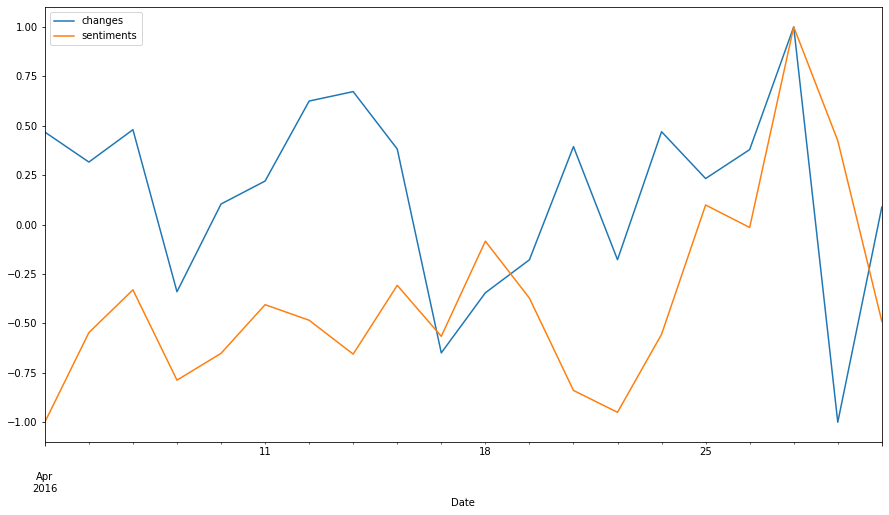

In [28]:
scaled.plot(figsize=(15, 8))

In [29]:
# shows the correlation
scaled.corr()

,changes,sentiments
changes,1.000000,0.050201
sentiments,0.050201,1.000000


 **Try sentiments with different date lags**

*   Sentiment shift backwards -> Current day sentiments predicts next day stock price change (**predictive_sentiment**)
*   Sentiment shift forwards -> Current day sentiments reflects yesterday's price change (**reactive_sentiment**)


In [30]:
# Sentiment shift backwards -> Current day sentiments predicts next day stock price change (predictive)
scaled['predictive_sentiment'] = merged['sentiments'].shift(-1)

# Sentiment shift forwards -> Current day sentiments reflects yesterday's price change (reactive)
scaled['reactive_sentiment'] = merged['sentiments'].shift(1)
scaled

,changes,sentiments,predictive_sentiment,reactive_sentiment
Date,,,,
2016-04-04,0.467997,-1.000000,-0.546644,NaN
2016-04-05,0.316221,-0.546644,-0.330259,-1.000000
2016-04-06,0.479928,-0.330259,-0.787139,-0.546644
2016-04-07,-0.339923,-0.787139,-0.651499,-0.330259
2016-04-08,0.103952,-0.651499,-0.405367,-0.787139
2016-04-11,0.220071,-0.405367,-0.484099,-0.651499
2016-04-12,0.624869,-0.484099,-0.655467,-0.405367
2016-04-13,0.672547,-0.655467,-0.307421,-0.484099
2016-04-14,0.382025,-0.307421,-0.565411,-0.655467


In [31]:
scaled.corr()

,changes,sentiments,predictive_sentiment,reactive_sentiment
changes,1.000000,0.050201,0.226050,-0.377999
sentiments,0.050201,1.000000,0.507959,0.507959
predictive_sentiment,0.226050,0.507959,1.000000,0.149999
reactive_sentiment,-0.377999,0.507959,0.149999,1.000000


**Notes**
* **Filter contents** with different conditions or use hashtags to get more "relevant" tweets to the company
* Use different **weightings** apart from the Followings
* Take sentiment **subjectivity** into account (maybe more subjective is more important)
* Is the **coverage** enough? Add different data source of sentiment
* Use a better **sentiment analysis engine** (e.g. tailored made with social media content and stock trading)
* Try with **different date lags** and compares the close price changes rather than open-close changes
* Price change comparing to **sentiment change** rather than raw sentiment scores
* Use sentiment **moving average** or long/short term sentiment cross over
* Combine with other **technical indicators** such as stock price moving average
* Combine with other Machine Learned **signals** or trends